<a href="https://colab.research.google.com/github/marekrei/ml-examples/blob/main/ML_examples_02_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Examples - 02 - Neural Networks

Predicting whether the income of a person is below or above 50K.
Implementing and training a neural network for binary classification.

We are using the census dataset: https://archive.ics.uci.edu/dataset/2/adult

Epoch 1/10, Loss: 0.3615
Epoch 2/10, Loss: 0.3163
Epoch 3/10, Loss: 0.3130
Epoch 4/10, Loss: 0.3093
Epoch 5/10, Loss: 0.3079
Epoch 6/10, Loss: 0.3071
Epoch 7/10, Loss: 0.3057
Epoch 8/10, Loss: 0.3044
Epoch 9/10, Loss: 0.3042
Epoch 10/10, Loss: 0.3030

Test Accuracy: 0.8582


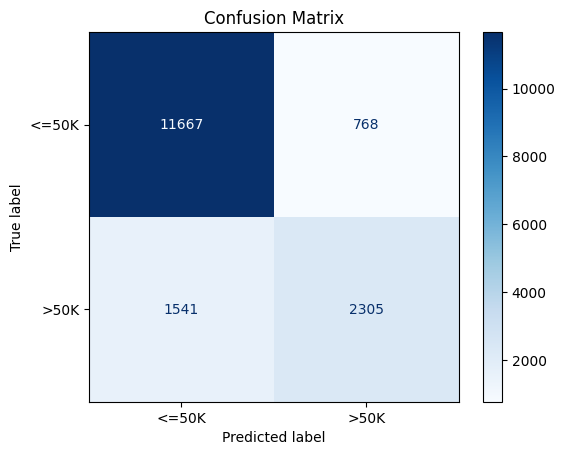

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Load datasets
train_data = pd.read_csv('https://raw.githubusercontent.com/marekrei/ml-examples/main/data/census_data/train.csv', skipinitialspace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/marekrei/ml-examples/main/data/census_data/test.csv', skipinitialspace=True)

# Separate features and labels
X_train = train_data.drop("income", axis=1)
y_train = (train_data["income"] == ">50K").astype(int)  # Convert to binary
X_test = test_data.drop("income", axis=1)
y_test = (test_data["income"] == ">50K").astype(int)

# Define continuous and categorical features
continuous_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Fit on training data and transform both train and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define a PyTorch Dataset class
class IncomeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = IncomeDataset(X_train_tensor, y_train_tensor)
test_dataset = IncomeDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple neural network model
class IncomePredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_layer_size):
        super(IncomePredictionModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_layer_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_layer_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Model hyperparameters
epochs = 10
learning_rate = 0.001
hidden_layer_size = 64

# Model initialization
input_dim = X_train_tensor.shape[1]
model = IncomePredictionModel(input_dim, hidden_layer_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        predictions.extend(outputs.numpy())
        true_labels.extend(labels.numpy())

predictions = np.array(predictions) >= 0.5
accuracy = accuracy_score(true_labels, predictions)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Display confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["<=50K", ">50K"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()